## To-Do:
- [ ] Given `ra` and `dec`, identify its `tract`
- [ ] Stack stars within this certain `tract`
- [ ] More tweaks about the center of PSF?

In [1]:
%load_ext autoreload
%autoreload 2
import os
import copy
import scipy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.stats import sigma_clip
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.nddata.utils import block_replicate, block_reduce

from photutils import CosineBellWindow, create_matching_kernel

from pyraf import iraf

In [2]:
import lvhuo
from lvhuo.display import display_single, draw_circles
from lvhuo.image import query_star, extract_obj

In [75]:
from unagi import hsc
from unagi import plotting
from unagi.task import hsc_cutout, hsc_tricolor, hsc_psf, hsc_check_coverage

# Setup HSC server
s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide', verbose=False)

In [61]:
obj_cat = Table.read('s16a_massive_z_0.5_logm_11.4_decals_full_fdfc_bsm_ell.fits', format='fits')

In [62]:
obj = obj_cat[4]
obj_coor = SkyCoord(obj['ra'], obj['dec'], unit='deg')

In [7]:
hdu = hsc_cutout(obj_coor, cutout_size=4 * u.arcmin, archive=s18a, filters='r')
img = hdu[1].data.byteswap().newbyteorder()
img_hdr = hdu[1].header
w = wcs.WCS(img_hdr)
hdu.close()
psf = hsc_psf(obj_coor, filters='r', archive=s18a)[0].data

# Retrieving cutout image in filter: r
# Retrieving coadd PSF model in filter: r


In [12]:
# Query GAIA stars
star_cat = query_star(img, img_hdr, method='gaia', bright_lim=21)
x, y = w.wcs_world2pix(star_cat['ra'], star_cat['dec'], 0)
fov_mask = (x < img.shape[1]) & (x > 0) & (y < img.shape[0]) & (y > 0)
star_cat = star_cat[fov_mask]
# Extract stars from image
objects, segmap = extract_obj(img, b=64, f=3, sigma=4.5, minarea=2,
                              deblend_nthresh=32, deblend_cont=0.005, 
                              sky_subtract=False, show_fig=False, flux_aper=[5, 10])
ra, dec = w.wcs_pix2world(objects['x'], objects['y'], 0)
objects.add_columns([Column(data=ra, name='ra'), Column(data=dec, name='dec')])
# Match two catalogs
temp = match_coordinates_sky(SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg'),
                             SkyCoord(ra=objects['ra'], dec=objects['dec'], unit='deg'))[0]
psf_cat = objects[temp] # here's the final star catalog
psf_cat = psf_cat[psf_cat['fwhm_custom'] < 10]

### Querying Gaia Data ###
# Detect 1931 objects


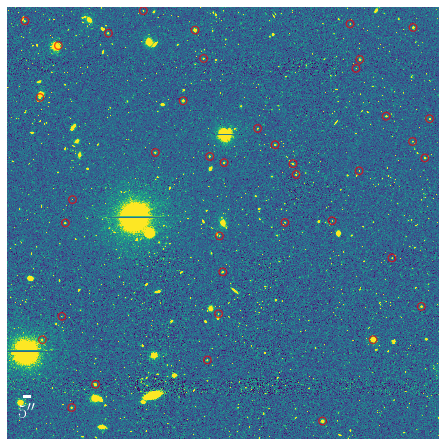

In [65]:
draw_circles(img, psf_cat, colnames=['x', 'y'], 
             header=img_hdr, circle_size=50)

In [14]:
from lvhuo.stack import psf_construct
from lvhuo.image import save_to_fits, circularize

In [64]:
halosize = 20
cutouts = np.zeros((len(psf_cat), halosize * 2 + 1, halosize * 2 + 1))
for i, obj in enumerate(psf_cat):
    psf_raw, psf_mask = psf_construct(img, obj['x'], obj['y'], 
                                      halosize, norm=obj['flux'], sub_indiv_bkg=False)
    psf_masked = psf_raw
    psf_masked[psf_mask.astype(bool)] = np.nan
    cutouts[i, :, :] = psf_masked
    
save_to_fits(cutouts, 'cutout_stack_set.fits')
# median of bright stars is halo model
stacked = np.nanmedian(cutouts, axis=0)

###
subtract_edge_bkg = False
if subtract_edge_bkg:
    # subtract background of halomodel - made up of residuals of neighboring objects
    edge = np.int(halosize / 5.)
    if edge < 3:
        edge = 3
    uni = np.ones_like(stacked)
    d = np.sum(stacked) - np.sum(stacked[edge: halosize * 2 - edge + 1, 
                                         edge: halosize * 2 - edge + 1])
    area = np.sum(uni) - np.sum(uni[edge: halosize * 2 - edge + 1, 
                                 edge: halosize * 2 - edge + 1])
    d /= u # Now 'd' is the background value per pixel
    stacked = stacked - d

# Normalize to 1
stacked /= np.sum(stacked)

In [211]:
from astropy.convolution import Box2DKernel, convolve
halomodel_sm = convolve(stacked, kernel=Box2DKernel(width=4))

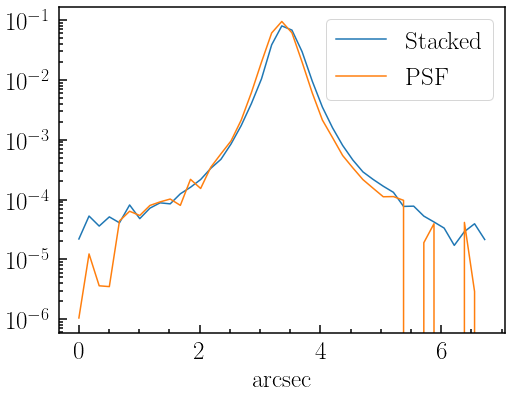

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(np.arange(0, 41, 1) * 0.168, stacked[20, :], label='$\mathrm{Stacked}$')
plt.plot(np.arange(0, 41, 1) * 0.168, psf[:, 1:-1][20, :], label='$\mathrm{PSF}$')
plt.yscale('log')
plt.xlabel('$\mathrm{arcsec}$')
plt.legend()

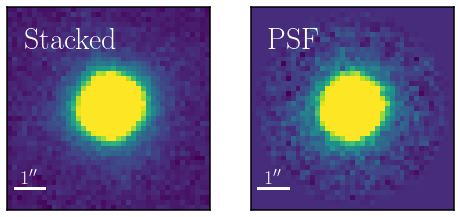

In [59]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 6))
display_single(stacked, ax=ax1, add_text='Stacked', 
               scale_bar_length=1, scale_bar_y_offset=1.2)
display_single(psf[:, 1:-1], ax=ax2, add_text='PSF', 
               scale_bar_length=1, scale_bar_y_offset=1.2)
plt.savefig('stack_stars.png', bbox_inches='tight', dpi=150)

In [69]:
from unagi.sky import SkyObjs

## Download color cutout for reference

In [63]:
hsc_tricolor(obj_coor, redshift=obj['z_best'], 
             cutout_size=4 * u.arcmin, 
             archive=s18a, save_rgb=True);

# RGB picture will be saved as ./dr2_s18a_wide_29.4190_-4.7008_4.00arcmin_gri.jpg
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
